In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# устанавливаем библиотеку pytorch lightning
!pip install pytorch_lightning --quiet

     |████████████████████████████████| 409kB 6.0MB/s 
     |████████████████████████████████| 276kB 14.7MB/s 
     |████████████████████████████████| 829kB 16.8MB/s 
     |████████████████████████████████| 2.8MB 29.8MB/s 
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.2.0 which is incompatible.


In [3]:
import numpy as np
import os
import shutil 
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.metrics import functional as FM

In [4]:
# распакуем архив и удалим ненужные файлы из него
!tar -xf "/content/drive/My Drive/NtechLab/internship_data.tar.gz"
!rm -r "/content/internship_data/male/.ipynb_checkpoints"
!rm -r "/content/internship_data/female/.ipynb_checkpoints"

# Config

In [5]:
class_names   = ['female', 'male']

data_dir      = '/content/internship_data'
train_dir     = 'train'
val_dir       = 'val'

# гиперпараметры
seed          = 42
val_split     = 0.10
batch_size    = 128
learning_rate = 0.2
epochs        = 5

# Utilities

In [6]:
def plot_batch(imgs, labels):
    """Отрисовывает 16 изображений из батча

        Parameters
        ----------
        imgs : массив элементов torch FloatTensor
            изображения для отрисовки
        labels : массив элементов torch IntTensor
            метки изображений
        """
    fig, axs = plt.subplots(4, 4, figsize=(20,15))
    
    for i in range(4):
        for j in range(4):
            img   = imgs[i*4 + j].permute([1, 2, 0]).numpy()
            label = class_names[labels[i*4 + j]]

            axs[i, j].imshow(img)
            axs[i, j].set_title(label)

def plot_predict(imgs, labels, preds):
    """Отрисовывает 16 изображений из батча
        и также предсказание класса для изображений

        Parameters
        ----------
        imgs : массив элементов torch FloatTensor
            изображения для отрисовки
        labels : массив элементов torch IntTensor
            метки изображений
        preds : массив элементов torch FloatTensor
            предсказание нейронной сети
        """
    fig, axs = plt.subplots(4, 4, figsize=(20,15))
    
    for i in range(4):
        for j in range(4):
            img   = imgs[i*4 + j].permute([1, 2, 0]).numpy()
            label = class_names[labels[i*4 + j]]
            pred  = class_names[preds[i*4 + j].argmax()]

            axs[i, j].imshow(img)
            axs[i, j].set_title("label : " + label + ", pred : " + pred)

# Dataset & Dataloader

In [7]:
# разобьем исходный датасет на две папки train и val

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

male_path   = os.path.join(data_dir, 'male')
female_path = os.path.join(data_dir, 'female')

train_male_files,   val_male_files   = train_test_split(os.listdir(male_path),   test_size=val_split, random_state=seed)
train_female_files, val_female_files = train_test_split(os.listdir(female_path), test_size=val_split, random_state=seed)

# тренировочные данные
for filename in train_male_files:
    source = os.path.join(data_dir,  'male', filename)
    dest   = os.path.join(train_dir, 'male', filename)
    shutil.copy(source, dest)

for filename in train_female_files:
    source = os.path.join(data_dir,  'female', filename)
    dest   = os.path.join(train_dir, 'female', filename)
    shutil.copy(source, dest)

# валидационные данные
for filename in val_male_files:
    source = os.path.join(data_dir, 'male', filename)
    dest   = os.path.join(val_dir,  'male', filename)
    shutil.copy(source, dest)

for filename in val_female_files:
    source = os.path.join(data_dir, 'female', filename)
    dest   = os.path.join(val_dir,  'female', filename)
    shutil.copy(source, dest)

In [8]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip()
])
val_transforms   = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset   = torchvision.datasets.ImageFolder(val_dir,   val_transforms)

In [18]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,   batch_size=batch_size, shuffle=True
)

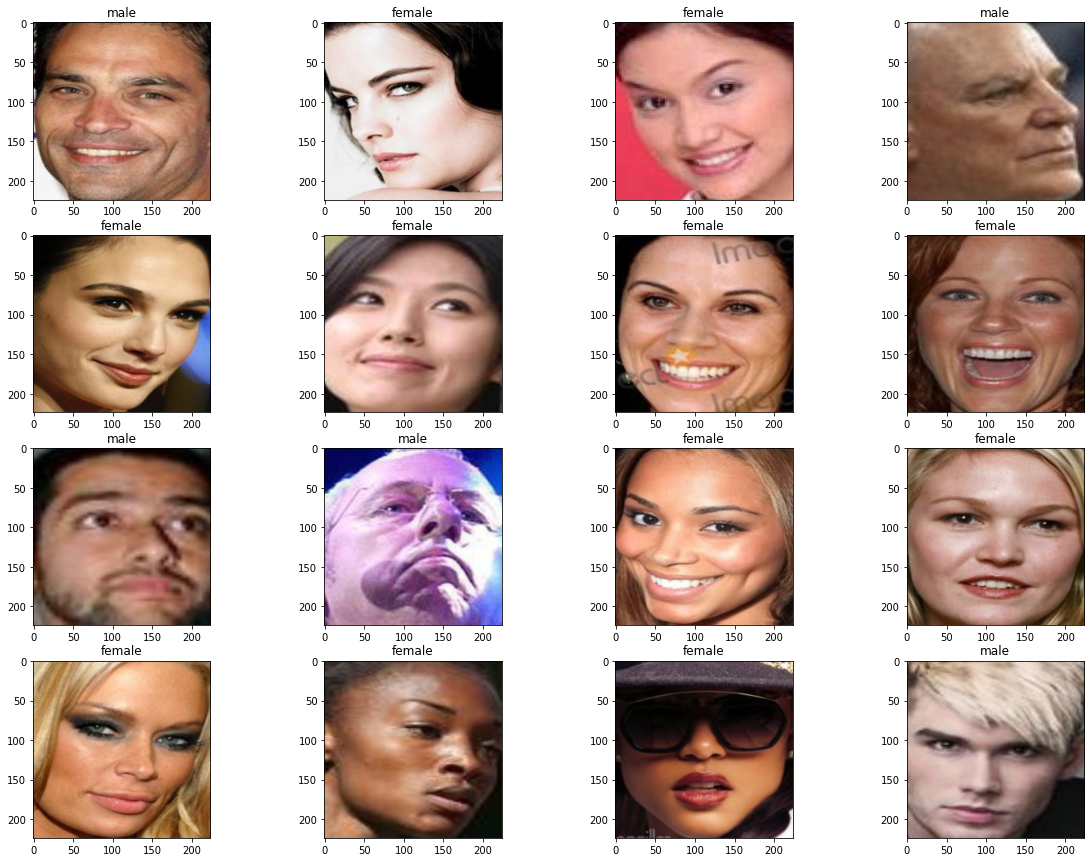

In [10]:
# посмотрим на изображения из батча

for X, Y in train_dataloader:
    plot_batch(X, Y)
    break

# Training model

In [11]:
class FaceClassifier(pl.LightningModule):
    """Класс FaceClassifier используется для обучения нейросети
    

    Methods
    -------
    forward(X)
        Прямой проход нейросети
    training_step(batch, batch_nb)
        тренировочный шаг обучения
    validation_step(batch, batch_idx):
        валидационный шаг обучения
    configure_optimizers():
        выбор оптимизатора для нейросети
    """

    def __init__(self):
        super().__init__()
        self.model  = models.resnet18(num_classes=2)

    def forward(self, X):
        return self.model(X)

    def training_step(self, batch, batch_nb):
        """тренировочный шаг обучения,
            сохраняет логи о лосс функции и метрики
        """
        X, y = batch
        pred = self(X)
        loss = F.cross_entropy(pred, y)
        acc  = FM.accuracy(pred, y, num_classes = 2)
        result = pl.TrainResult(loss)
        result.log_dict({'train_acc': acc, 'train_loss': loss}, on_epoch=True)  
        return result
        
    def validation_step(self, batch, batch_idx):
        """валидационный шаг обучения,
            сохраняет логи о лосс функции и метрики
        """
        x, y = batch
        pred = self(x)
        loss = F.cross_entropy(pred, y)
        acc  = FM.accuracy(pred, y, num_classes = 2)
        result = pl.EvalResult(checkpoint_on=loss)
        result.log_dict({'val_acc': acc, 'val_loss': loss})
        return result

    def configure_optimizers(self):
        """инициализация оптимизера
        """
        return torch.optim.Adam(self.parameters(), lr=learning_rate)

classifier = FaceClassifier()
trainer = Trainer(max_epochs=epochs, gpus=-1)
trainer.fit(classifier, train_dataloader, val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11 M  


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: You have set 2 number of classes if different from predicted (1) and target (1) number of classes
  warnings.warn(*args, **kwargs)


Saving latest checkpoint..


1

# Result

In [13]:
# посмотрим на графики функций потерь и метрик

%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs

<IPython.core.display.Javascript object>

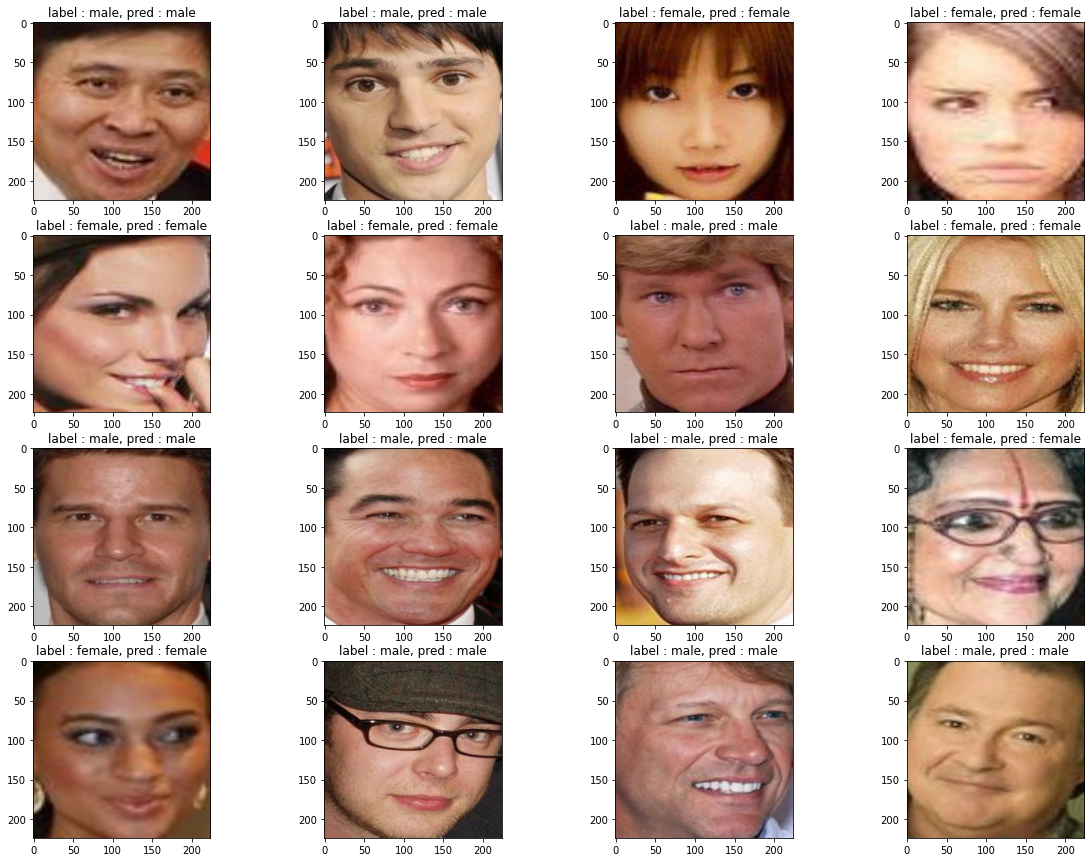

In [19]:
# предсказания на валидационных данных

for X, Y in val_dataloader:
    preds = classifier(X)
    plot_predict(X, Y, preds)
    break

In [17]:
# сохраним модель

save_path = "/content/drive/My Drive/NtechLab/face_model.pth"
torch.save(classifier.model.state_dict(), save_path)